In [1]:
!git clone https://github.com/RInkalshah93/ERA-V2-Support.git

Cloning into 'ERA-V2-Support'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 40 (delta 14), reused 34 (delta 8), pack-reused 0
Receiving objects: 100% (40/40), 8.97 KiB | 8.97 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [2]:
!pip install grad-cam
!pip install torch-lr-finder
!pip install torchsummary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#import model
import matplotlib.pyplot as plt
import numpy as np
%cd ERA-V2-Support
from Model.model_10 import Model_10
import dataset
import train
import utils



/content/ERA-V2-Support


In [4]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

train_data = dataset.train()
test_data = dataset.test()
if cuda:
    batch_size = 512
    shuffle = True
    num_workers = 4
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)
else:
    batch_size =256
    shuffle = True
    num_workers =2
    pin_memory = True
    train_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,train_data)
    test_loader = dataset.get_train_loader(batch_size,shuffle,num_workers,pin_memory,test_data)


CUDA Available? True


100%|██████████| 170498071/170498071 [00:03<00:00, 48598076.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


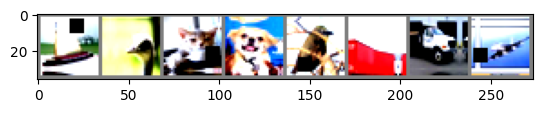

ship  bird  cat   dog  


In [5]:
# functions to show an image
utils.plot_image(train_loader)

In [6]:
device = utils.get_device()
model = Model_10().to(device)
utils.model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-04


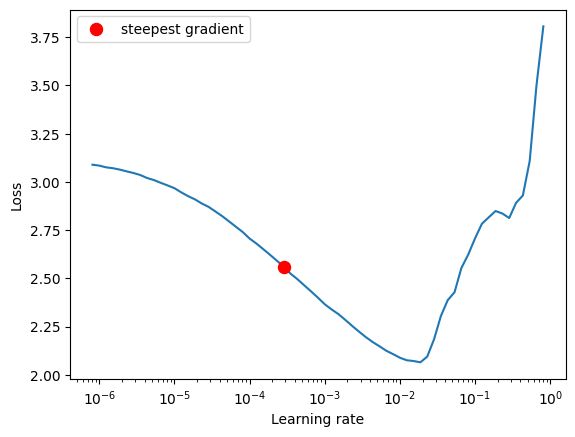

In [7]:
criterion = nn.CrossEntropyLoss()
max_lr, optimizer = utils.get_max_lr(model, train_loader,criterion)

In [8]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=10,
        three_phase=False,
        final_div_factor=1,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_acc, train_losses = train.train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc, test_losses = train.test(model, device, test_loader, criterion)
    print("LR for current epoch: ",scheduler.get_last_lr())

EPOCH: 0


Loss=1.383655071258545 LR=7.984983999234115e-05 Batch_id=97 Accuracy=37.64: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]



Test set: Average loss: 0.0026, Accuracy: 5437/10000 (54.37%)

LR for current epoch:  [7.984983999234115e-05]
EPOCH: 1


Loss=1.129591464996338 LR=0.00013121932130032428 Batch_id=97 Accuracy=56.07: 100%|██████████| 98/98 [00:18<00:00,  5.32it/s]



Test set: Average loss: 0.0023, Accuracy: 5948/10000 (59.48%)

LR for current epoch:  [0.00013121932130032428]
EPOCH: 2


Loss=1.0403175354003906 LR=0.00018258880260830745 Batch_id=97 Accuracy=64.24: 100%|██████████| 98/98 [00:18<00:00,  5.25it/s]



Test set: Average loss: 0.0020, Accuracy: 6511/10000 (65.11%)

LR for current epoch:  [0.00018258880260830745]
EPOCH: 3


Loss=0.873642086982727 LR=0.00023395828391629058 Batch_id=97 Accuracy=70.12: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.0018, Accuracy: 6923/10000 (69.23%)

LR for current epoch:  [0.00023395828391629058]
EPOCH: 4


Loss=0.7000810503959656 LR=0.000284665926678081 Batch_id=97 Accuracy=74.39: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.0014, Accuracy: 7558/10000 (75.58%)

LR for current epoch:  [0.000284665926678081]
EPOCH: 5


Loss=0.6369854807853699 LR=0.00027117523045917455 Batch_id=97 Accuracy=78.02: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.0012, Accuracy: 8004/10000 (80.04%)

LR for current epoch:  [0.00027117523045917455]
EPOCH: 6


Loss=0.5252479314804077 LR=0.0002576845342402681 Batch_id=97 Accuracy=80.85: 100%|██████████| 98/98 [00:19<00:00,  5.10it/s]



Test set: Average loss: 0.0012, Accuracy: 7971/10000 (79.71%)

LR for current epoch:  [0.0002576845342402681]
EPOCH: 7


Loss=0.5307620763778687 LR=0.0002441938380213617 Batch_id=97 Accuracy=82.85: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.0010, Accuracy: 8193/10000 (81.93%)

LR for current epoch:  [0.0002441938380213617]
EPOCH: 8


Loss=0.4291326403617859 LR=0.00023070314180245527 Batch_id=97 Accuracy=84.28: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 0.0009, Accuracy: 8382/10000 (83.82%)

LR for current epoch:  [0.00023070314180245527]
EPOCH: 9


Loss=0.404280424118042 LR=0.00021721244558354884 Batch_id=97 Accuracy=85.68: 100%|██████████| 98/98 [00:19<00:00,  5.08it/s]



Test set: Average loss: 0.0009, Accuracy: 8379/10000 (83.79%)

LR for current epoch:  [0.00021721244558354884]
EPOCH: 10


Loss=0.32490459084510803 LR=0.0002037217493646424 Batch_id=97 Accuracy=86.45: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.0009, Accuracy: 8485/10000 (84.85%)

LR for current epoch:  [0.0002037217493646424]
EPOCH: 11


Loss=0.25578129291534424 LR=0.00019023105314573598 Batch_id=97 Accuracy=87.39: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]



Test set: Average loss: 0.0009, Accuracy: 8429/10000 (84.29%)

LR for current epoch:  [0.00019023105314573598]
EPOCH: 12


Loss=0.28349924087524414 LR=0.00017674035692682958 Batch_id=97 Accuracy=88.36: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.0008, Accuracy: 8707/10000 (87.07%)

LR for current epoch:  [0.00017674035692682958]
EPOCH: 13


Loss=0.35077768564224243 LR=0.00016324966070792315 Batch_id=97 Accuracy=89.31: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]



Test set: Average loss: 0.0009, Accuracy: 8568/10000 (85.68%)

LR for current epoch:  [0.00016324966070792315]
EPOCH: 14


Loss=0.2862449884414673 LR=0.00014975896448901673 Batch_id=97 Accuracy=89.96: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 0.0008, Accuracy: 8687/10000 (86.87%)

LR for current epoch:  [0.00014975896448901673]
EPOCH: 15


Loss=0.29995396733283997 LR=0.00013626826827011033 Batch_id=97 Accuracy=91.07: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]



Test set: Average loss: 0.0008, Accuracy: 8655/10000 (86.55%)

LR for current epoch:  [0.00013626826827011033]
EPOCH: 16


Loss=0.25410598516464233 LR=0.0001227775720512039 Batch_id=97 Accuracy=91.32: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0007, Accuracy: 8832/10000 (88.32%)

LR for current epoch:  [0.0001227775720512039]
EPOCH: 17


Loss=0.23742659389972687 LR=0.00010928687583229744 Batch_id=97 Accuracy=92.41: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]



Test set: Average loss: 0.0008, Accuracy: 8735/10000 (87.35%)

LR for current epoch:  [0.00010928687583229744]
EPOCH: 18


Loss=0.2432313710451126 LR=9.579617961339104e-05 Batch_id=97 Accuracy=92.82: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 0.0007, Accuracy: 8822/10000 (88.22%)

LR for current epoch:  [9.579617961339104e-05]
EPOCH: 19


Loss=0.1812770664691925 LR=8.230548339448462e-05 Batch_id=97 Accuracy=93.68: 100%|██████████| 98/98 [00:19<00:00,  5.03it/s]



Test set: Average loss: 0.0007, Accuracy: 8834/10000 (88.34%)

LR for current epoch:  [8.230548339448462e-05]
EPOCH: 20


Loss=0.1260371059179306 LR=6.881478717557822e-05 Batch_id=97 Accuracy=94.34: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]



Test set: Average loss: 0.0006, Accuracy: 8932/10000 (89.32%)

LR for current epoch:  [6.881478717557822e-05]
EPOCH: 21


Loss=0.19141919910907745 LR=5.532409095667176e-05 Batch_id=97 Accuracy=95.39: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]



Test set: Average loss: 0.0006, Accuracy: 9052/10000 (90.52%)

LR for current epoch:  [5.532409095667176e-05]
EPOCH: 22


Loss=0.17014309763908386 LR=4.183339473776536e-05 Batch_id=97 Accuracy=95.91: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0006, Accuracy: 9077/10000 (90.77%)

LR for current epoch:  [4.183339473776536e-05]
EPOCH: 23


Loss=0.09297896921634674 LR=2.834269851885896e-05 Batch_id=97 Accuracy=96.62: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.0005, Accuracy: 9117/10000 (91.17%)

LR for current epoch:  [2.834269851885896e-05]


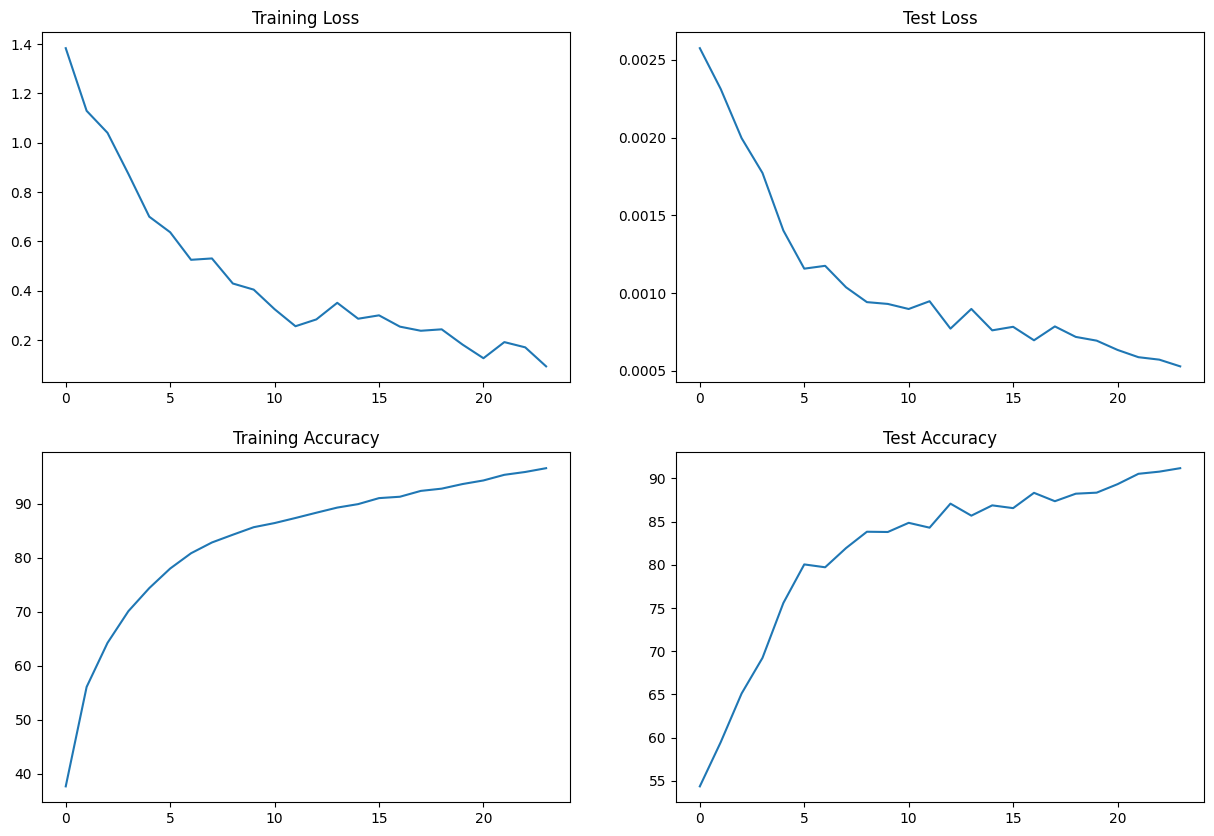

In [9]:
train.plot_loss_accuracy(train_losses,train_acc,test_losses,test_acc)

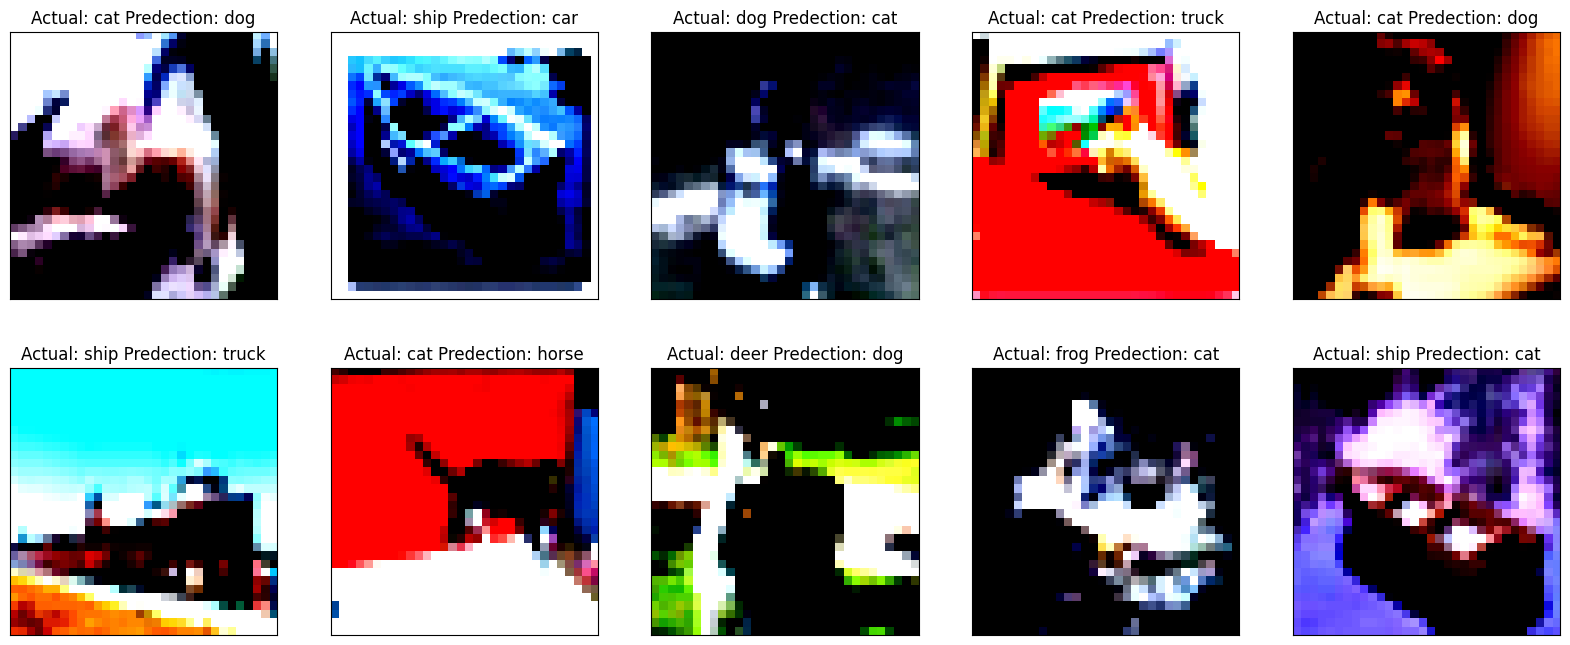

In [11]:
misclassified_images,misclassified_labels,misclassified_predictions,prediction = utils.plot_prediction_image(test_loader,device,model)